
# **1. Product 概要**
---

1.1  名称  

---

*  simpleNN  
  
---

1.2  製作目論見  

---
*  ニューラルネットワークによる機械学習(初歩)の習得  
*  Pythonの習得
    *  Python選定理由
        *  行列演算モジュール(Numpyライブラリ)を利用することで行列演算が直感的かつ簡素に実装できるため
        *  数値計算結果などの可視化ライブラリ(Matplotlibライブラリ)が充実しているため  
        *  各層において、コードを再利用することで簡素に実装できるため(Object志向)    
          *  個人的な所感としては、上記3点により直感的かつ素直に実装できると理解   
*  ニューラルネットワークによる学習経過を閲覧者に楽しんでいただく  


# **2. Productに適用したニューラルネットワークの概要図**

---

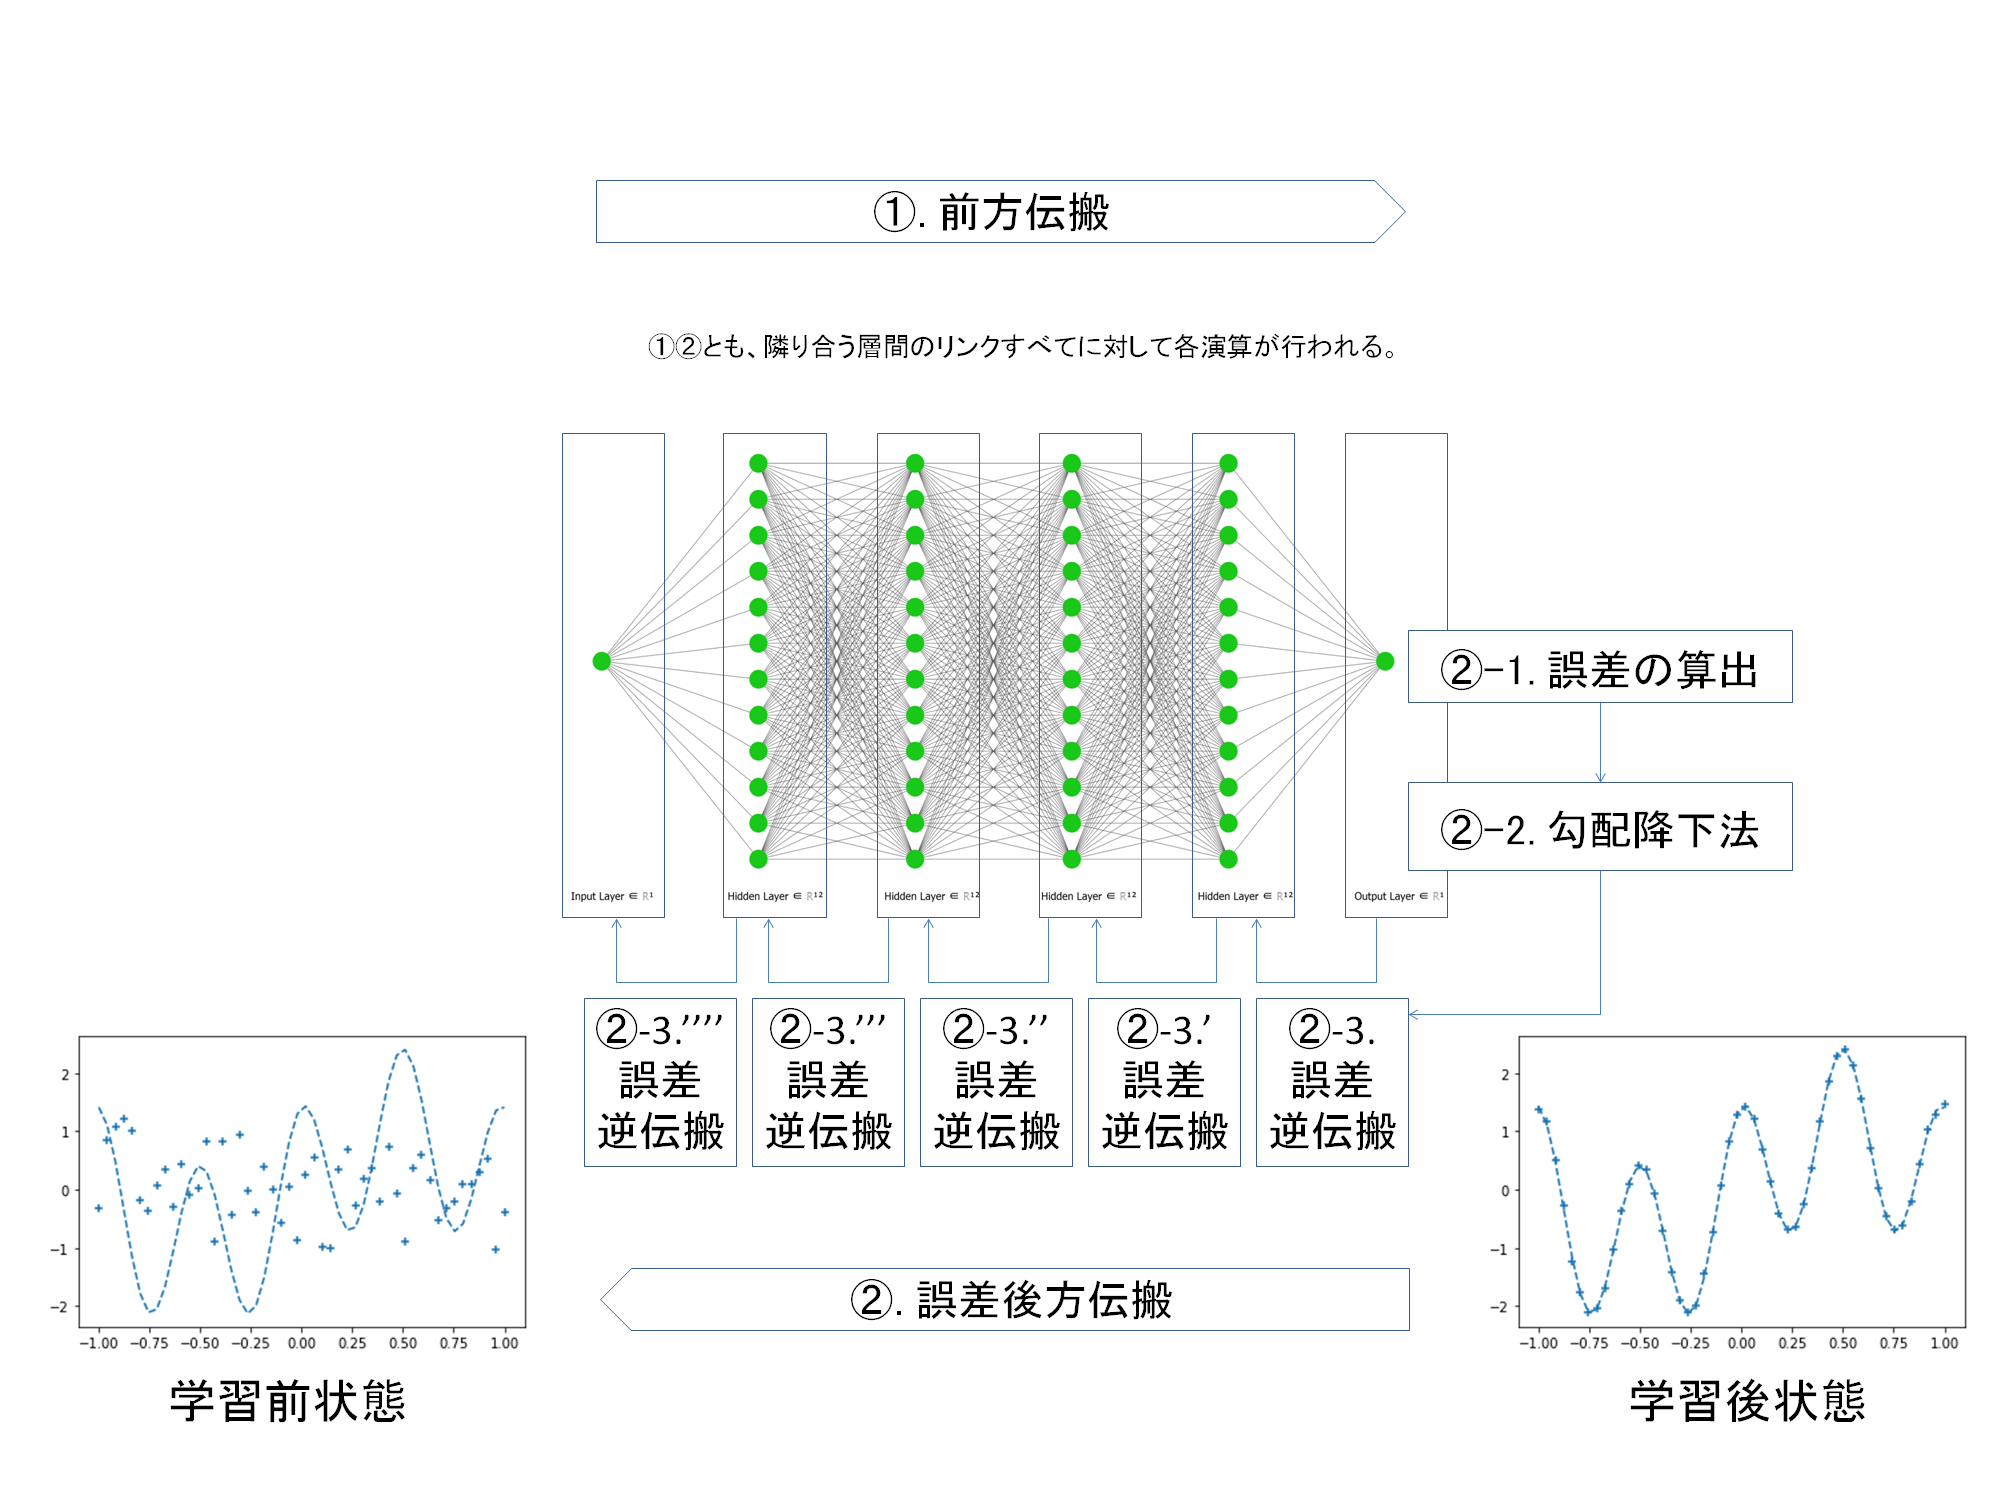


# **3. Product 内部概説**

---

3.1 数学的説明に関する前提    

---

*  数学表現に馴染みのある閲覧者を対象として、援用するにとどめる。  
    (基礎数学の解説は、代数学・解析学ともに割愛)  

---

3.2 対象とする問題  

---

*  回帰問題  

*  回帰問題とは
  *  二種類に大別される機械学習の一方    
    *  回帰問題 ⇒ データ傾向から連続的な数値を予測する。 (prediction)  (e.g. 雇用指数, 株価, ...)
    *  分類問題 ⇒ 特徴を抽出し分類する。  (clustering)  (e.g. 男性, 女性, ...)

---

3.3 学習アルゴリズム  

---

*  ニューラルネットワーク(NN)による教師付学習(SVM)  
  *  ①.  前方伝搬(入力レイヤから出力レイヤへ向かって訓練データを伝搬)  
  *  ②.  誤差修正(出力レイヤで誤差を計測)  
    *  ②-1.  誤差の算出 ⇒ 出力レイヤに、損失関数として二乗和誤差(SSE)を適用して算出  
    *  ②-2.  勾配降下法 ⇒ 損失関数の勾配(接線の傾き)を減らす方向へ重みを調整し、損失関数を最小化させる手法  
      (勾配の求め方 ⇒ 損失関数を偏微分で算出)  
    *  ②-3.  誤差逆伝搬 ⇒ 出力レイヤから入力レイヤへニューラルネットワークを遡って誤差を伝搬  
*  バッチサイズ: 1  
    *  バッチサイズが1の場合は、オンライン学習となる(リアルタイム計算のイメージ) 
      *  バッチ: 計算効率を向上させるため、エポックを分割実施する手法  
        *  エポック:  機械計算による一連のデータ演算一式  

*  Epoch数: 8,001  
    *  表示インターバル: 400学習毎  
*  入力データ数
  *  50個 ( $x$ = -1 ～ +1, tick = 0.04)
    *  簡単化のため、特別に訓練データは準備せず、各$x$に対し$y$をランダムに生成することで訓練データの代替としている。

---

## **数学による補足**

---

*  単一ニューロンの数学モデル  

---

$$ u = \sum_{k=1}^n(x_kw_k) + b $$

---

*   活性化関数  

---
  *  隠れ層 / 前方伝搬:  シグモイド関数    
  *  出力層 / 前方伝搬:  恒等関数  
      *  シグモイド関数  
$$f(x) = \frac{1}{1+\exp(-x)}$$
      *  恒等関数  
$$ f(x) = x $$ 

---

*  2層間の前方伝搬の数学表現  

---

  *  それぞれの層には複数のニューロンが含まれることから、ベクター($\vec{u_j}$, $\vec{x_j}$, $\vec{b_j}$)と行列($W$)からなる表現となる。  
  *  換言すれば、単一ニューロンの数学モデルを層に適用した表現ともいえる。
$$  \begin{aligned} \\
\vec{u_j} & = \vec{x_j} W + \vec{b_j} \\
    & = (x_1, x_2, \cdots, x_m)
   \left(
    \begin{array}{cccc}
      w_{11} & w_{12} & \ldots & w_{1n} \\
      w_{21} & w_{22} & \ldots & w_{2n} \\
      \vdots & \vdots & \ddots & \vdots \\
      w_{m1} & w_{m2} & \ldots & w_{mn} \\
    \end{array}
  \right) 
 + (b_1, b_2, \cdots, b_n) \\
  & = (\sum\limits_{k=1}^m x_kw_{k1}+b_1, \sum\limits_{k=1}^m x_kw_{k2}+b_2, \ldots, \sum\limits_{k=1}^m x_kw_{kn}+b_n)
  \end{aligned}
  $$  
  *  活性化関数$f$で処理し、出力$\vec{y_j}$は次のように表現できる。  
$$ \begin{aligned}
  \vec{y_j} & = (y_1, y_2, \cdots, y_n) \\
  & = f(\vec{u_j}) \\
  & = f(\vec{x_j}W + \vec{b_j}) \\
  & = f(\sum\limits_{k=1}^m x_kw_{k1}+b_1), f(\sum\limits_{k=1}^m x_kw_{k2}+b_2), \ldots, f(\sum\limits_{k=1}^m x_kw_{kn}+b_n)
\end{aligned} $$  

---

*  損失関数  

---

*  出力層で、誤差の算出に用いる関数  
*  出力層の全ニューロンで、出力値と正解値の差を二乗し、それらを総和する関数  
$$ E = \frac{1}{2} \sum_{k}(y_k-t_k)^2 $$
$E$ : 誤差総和  
$y_k$ : 出力層の$k$番目の出力値  
$t_k$ : $k$番目の正解値  

---

*  出力層の各勾配  

---
*  $k$番目の誤差($y_k-t_k$)を$\delta_{k}$とおく。  
$$ \delta_{k} = y_k-t_k $$
*  入力の勾配  
$$ \frac{\partial E}{\partial y_j} =  \sum_{r=1}^n \delta_r w_{jr} $$
*  重みの勾配  
$$ \frac{\partial E}{\partial w_{jk}} = y_j \delta_{k}  $$
*  バイアスの勾配  
$$ \frac{\partial E}{\partial b_k} = \delta_{k} $$
*出力の勾配  
$$ \frac{\partial E}{\partial y_j} = \sum_{r=1}^n \delta_r w_{jr}$$

---

*  隠れ層の各勾配  

---

*  入力の勾配  
$$ \delta_{j} = \frac{\partial y_j}{\partial u_j}(1-y_j)y_j $$
*  重みの勾配  
$$ \frac{\partial E}{\partial w_{ij}} = y_i\delta_{j} $$
*  バイアスの勾配  
$$ \frac{\partial E}{\partial b_j} = \delta_{j} $$
*  出力の勾配  
$$ \frac{\partial E}{\partial y_j} =  \sum_{q=1}^m \delta_q w_{iq} $$

---

*  前方伝搬の行列による表現  

---

*  入力と重みの行列積  
    *  $X$:  入力を表す行列  
        *  行数:  バッチサイズ(計算を分割して行う場合の分割単位のこと)  $h$  
        *  列数:  各層の、各ニューロンへの入力数  $m$  
        *  入力行列のサイズ:  $h$ x $m$  
    *  $W$:  重みを表す行列  
        *  行数:  各層の、各ニューロンへの入力数  $m$  
        *  列数:  各層のニューロン数  $n$  
        *  重み行列のサイズ:  $m$ x $n$  
    *  $X$$W$(行列積)の各要素:  入力と重みの積の総和  
$$  \begin{aligned} \\
XW & = \left(
    \begin{array}{cc}
      x_{11} & x_{12} & \ldots & x_{1m} \\
      x_{21} & x_{22} & \ldots & x_{2m} \\
      \vdots & \vdots & \ddots & \vdots \\
      x_{h1} & x_{h2} & \ldots & x_{hm} \\
    \end{array}
  \right)
\left(
    \begin{array}{cccc}
      w_{11} & w_{12} & \ldots & w_{1n} \\
      w_{21} & w_{22} & \ldots & w_{2n} \\
      \vdots & \vdots & \ddots & \vdots \\
      w_{m1} & w_{m2} & \ldots & w_{mn} \\
    \end{array}
  \right) \\
  & = \left(
    \begin{array}{cccc}
      \sum\limits_{k=1}^m x_{1k}w_{k1} & \sum\limits_{k=1}^m x_{1k}w_{k2} & \ldots & \sum\limits_{k=1}^m x_{1k}w_{kn} \\
       \sum\limits_{k=1}^m x_{2k}w_{k1} & \sum\limits_{k=1}^m x_{2k}w_{k2} & \ldots & \sum\limits_{k=1}^m x_{2k}w_{kn} \\
      \vdots & \vdots & \ddots & \vdots \\
      \sum\limits_{k=1}^m x_{hk}w_{k1} & \sum\limits_{k=1}^m x_{hk}w_{k2} & \ldots & \sum\limits_{k=1}^m x_{hk}w_{kn} \\
    \end{array}
  \right)
  \end{aligned}
  $$ 
*  バイアス足し合わせ  
    *  Numpyブロードキャスト利用  
$$ \vec{b} = (b_1, b_2, \cdots, b_n) $$
$$  \begin{aligned} \\
U & = \left(
    \begin{array}{cccc}
      \sum\limits_{k=1}^m x_{1k}w_{k1}+b_{1} & \sum\limits_{k=1}^m x_{1k}w_{k2}+b_{2} & \ldots & \sum\limits_{k=1}^m x_{1k}w_{kn}+b_{n} \\
       \sum\limits_{k=1}^m x_{2k}w_{k1}+b_{1} & \sum\limits_{k=1}^m x_{2k}w_{k2}+b_{2} & \ldots & \sum\limits_{k=1}^m x_{2k}w_{kn}+b_{n} \\
      \vdots & \vdots & \ddots & \vdots \\
      \sum\limits_{k=1}^m x_{hk}w_{k1}+b_{1} & \sum\limits_{k=1}^m x_{hk}w_{k2}+b_{2} & \ldots & \sum\limits_{k=1}^m x_{hk}w_{kn}+b_{n} \\
    \end{array}
  \right)
  \end{aligned}
  $$ 
*  層の出力$Y$
    *  行列の各要素を活性化関数$f$で処理  
    *  $h$(バッチサイズ) x $n$(ニューロン数)  
$$  \begin{aligned} \\
Y & = f(U) \\
 & = \left(
    \begin{array}{cccc}
      f(\sum\limits_{k=1}^m x_{1k}w_{k1}+b_{1}) & f(\sum\limits_{k=1}^m x_{1k}w_{k2}+b_{2}) & \ldots & f(\sum\limits_{k=1}^m x_{1k}w_{kn}+b_{n}) \\
       f(\sum\limits_{k=1}^m x_{2k}w_{k1}+b_{1}) & f(\sum\limits_{k=1}^m x_{2k}w_{k2}+b_{2}) & \ldots & f(\sum\limits_{k=1}^m x_{2k}w_{kn}+b_{n}) \\
      \vdots & \vdots & \ddots & \vdots \\
      f(\sum\limits_{k=1}^m x_{hk}w_{k1}+b_{1}) & f(\sum\limits_{k=1}^m x_{hk}w_{k2}+b_{2}) & \ldots & f(\sum\limits_{k=1}^m x_{hk}w_{kn}+b_{n}) \\
    \end{array}
  \right)
  \end{aligned}
  $$

---

*  誤差逆伝搬の行列による表現  

---

*  重みの勾配の行列(バッチ対応織り込み済み)   
    *  $X$と$\Delta$の行列積  
        *  $X$を転置:  $X^{\mathrm{T}}$  
    *  行列の各要素  
        *  バッチ内総和と同値  
    *  行列のサイズ
        *  $m$ x $n$:  前方伝搬の$W$のサイズと一致  
$$  \begin{aligned} \\
\frac{\partial E}{\partial W} & = X^{\mathrm{T}}\Delta \\
& = \left(
    \begin{array}{cc}
      x_{11} & x_{21} & \ldots & x_{h1} \\
      x_{12} & x_{22} & \ldots & x_{h2} \\
      \vdots & \vdots & \ddots & \vdots \\
      x_{1m} & x_{2m} & \ldots & x_{hm} \\
    \end{array}
  \right)
\left(
    \begin{array}{cccc}
      \delta_{11} & \delta_{12} & \ldots & \delta_{1n} \\
      \delta_{21} & \delta_{22} & \ldots & \delta_{2n} \\
      \vdots & \vdots & \ddots & \vdots \\
      \delta_{h1} & \delta_{h2} & \ldots & \delta_{hn} \\
    \end{array}
  \right) \\
& = \left(
    \begin{array}{cc}
      \sum\limits_{k=1}^hx_{k1}\delta_{k1} & \sum\limits_{k=1}^hx_{k1}\delta_{k2} & \ldots & \sum\limits_{k=1}^hx_{k1}\delta_{kn} \\
      \sum\limits_{k=1}^hx_{k2}\delta_{k1} & \sum\limits_{k=1}^hx_{k2}\delta_{k2} & \ldots & \sum\limits_{k=1}^hx_{k2}\delta_{kn} \\
      \vdots & \vdots & \ddots & \vdots \\
      \sum\limits_{k=1}^hx_{km}\delta_{k1} & \sum\limits_{k=1}^hx_{km}\delta_{k2} & \ldots & \sum\limits_{k=1}^hx_{km}\delta_{kn} \\
    \end{array}
  \right)
  \end{aligned}
  $$ 
*  バイアスの勾配(バッチ対応織り込み済み)  
$$ \sum_{k=1}^{h} \frac{\partial E_k}{\partial b_j}  $$
*  入力の勾配(バッチ対応織り込み済み)  
    *  $W$と$\Delta$の行列積  
        *  $W$を転置:  $W^{\mathrm{T}}$  
    *  行列の各要素  
        *  バッチ内総和と同値  
    *  行列のサイズ  
        *  $m$ x $n$:  前方伝搬の$W$のサイズと一致  
$$  \begin{aligned} \\
\frac{\partial E}{\partial W} & = \Delta W^{\mathrm{T}} \\
& = \left(
    \begin{array}{cccc}
      \delta_{11} & \delta_{12} & \ldots & \delta_{1n} \\
      \delta_{21} & \delta_{22} & \ldots & \delta_{2n} \\
      \vdots & \vdots & \ddots & \vdots \\
      \delta_{h1} & \delta_{h2} & \ldots & \delta_{hn} \\
    \end{array}
  \right) 
\left(
    \begin{array}{cccc}
      w_{11} & w_{21} & \ldots & w_{m1} \\
      w_{12} & w_{22} & \ldots & w_{m2} \\
      \vdots & \vdots & \ddots & \vdots \\
      w_{1n} & w_{2n} & \ldots & w_{mn} \\
    \end{array}
  \right)\\
& = \left(
    \begin{array}{cc}
      \sum\limits_{k=1}^n\delta_{1k}w_{1k} & \sum\limits_{k=1}^n\delta_{1k}w_{2k} & \ldots & \sum\limits_{k=1}^n\delta_{1k}w_{mk} \\
      \sum\limits_{k=1}^n\delta_{2k}w_{1k} & \sum\limits_{k=1}^n\delta_{2k}w_{2k} & \ldots & \sum\limits_{k=1}^n\delta_{2k}w_{mk} \\
      \vdots & \vdots & \ddots & \vdots \\
      \sum\limits_{k=1}^n\delta_{hk}w_{1k} & \sum\limits_{k=1}^n\delta_{hk}w_{2k} & \ldots & \sum\limits_{k=1}^n\delta_{hk}w_{mk}\\
    \end{array}
  \right)
  \end{aligned}
  $$ 

# **4. Pythonによる実装**

**(A series of results will show up anytime you make it fire.  )**

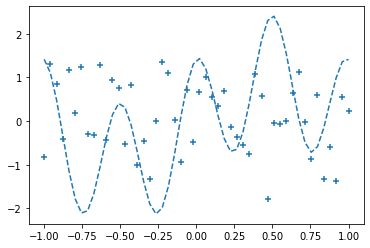

Epoch:0/8001       Error(MSE):1.1482822200867802


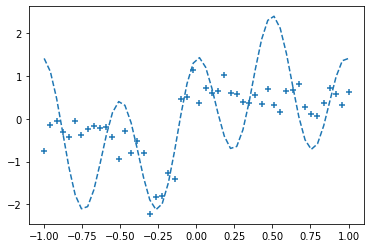

Epoch:400/8001       Error(MSE):0.4966156504628589


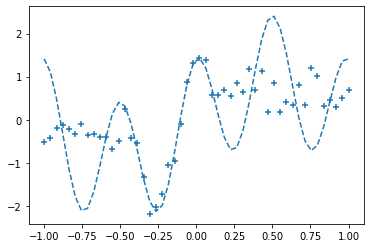

Epoch:800/8001       Error(MSE):0.49731156473178756


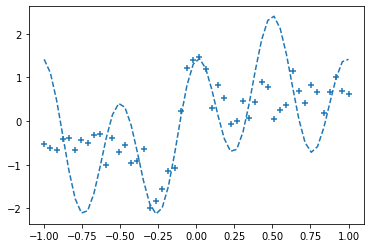

Epoch:1200/8001       Error(MSE):0.4574674262561561


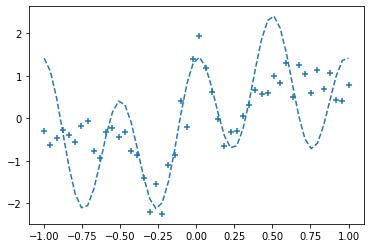

Epoch:1600/8001       Error(MSE):0.415893386001301


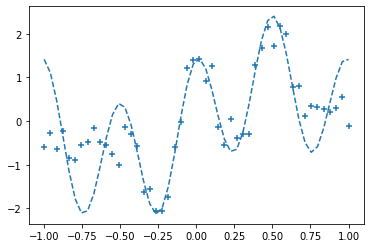

Epoch:2000/8001       Error(MSE):0.27961351449747246


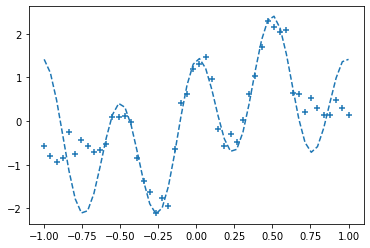

Epoch:2400/8001       Error(MSE):0.2586790468725384


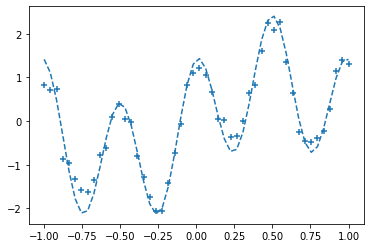

Epoch:2800/8001       Error(MSE):0.03128510139611219


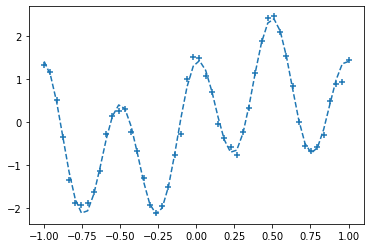

Epoch:3200/8001       Error(MSE):0.007339520522941643


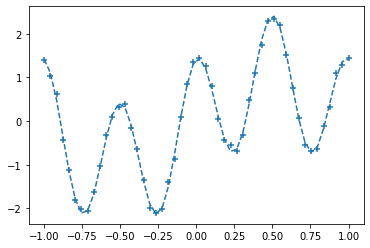

Epoch:3600/8001       Error(MSE):0.0023512341716862973


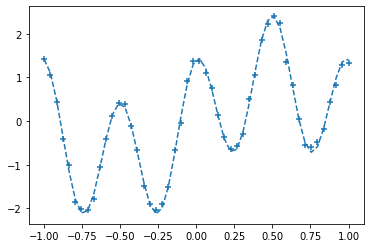

Epoch:4000/8001       Error(MSE):0.0030134828980638837


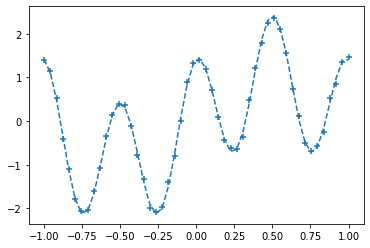

Epoch:4400/8001       Error(MSE):0.001569098431897252


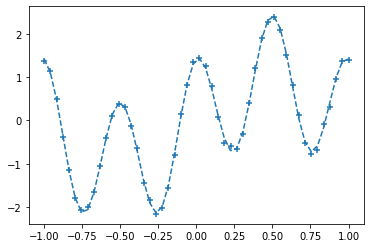

Epoch:4800/8001       Error(MSE):0.0013406501831288928


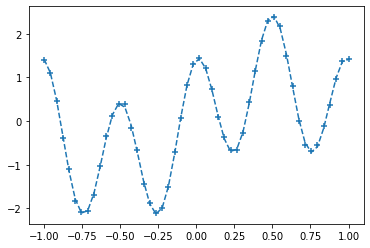

Epoch:5200/8001       Error(MSE):0.0006671059253445064


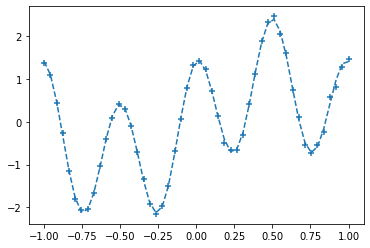

Epoch:5600/8001       Error(MSE):0.0013991721283434502


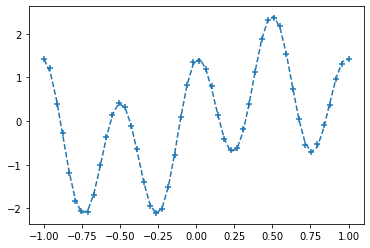

Epoch:6000/8001       Error(MSE):0.0009335658154968806


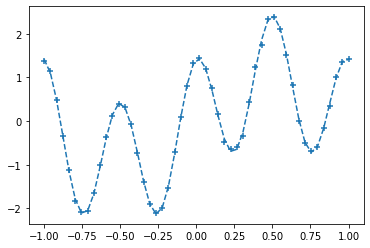

Epoch:6400/8001       Error(MSE):0.0007533681809968278


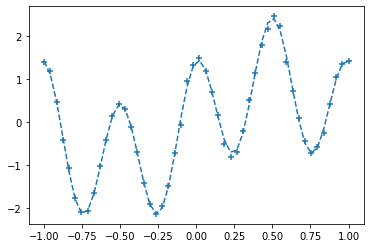

Epoch:6800/8001       Error(MSE):0.0020334845517976635


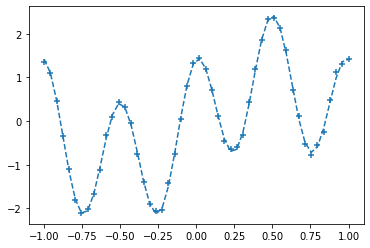

Epoch:7200/8001       Error(MSE):0.0011984443952984681


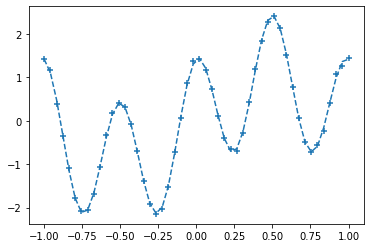

Epoch:7600/8001       Error(MSE):0.0007236198690454925


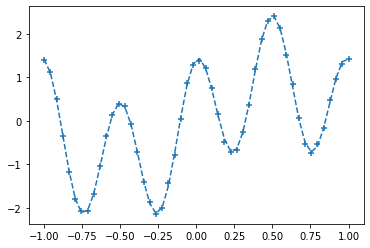

Epoch:8000/8001       Error(MSE):0.0005123006929113365


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# -- generate original input data and define correct data --
input_data = np.linspace(-np.pi, np.pi)  # original input dataset
correct_data = np.sin(input_data) + np.sqrt(2) * np.cos(4 * input_data) # correct dataset
input_data = input_data/np.pi            # normalize the data realm from -1.0 to 1.0
n_data = len(correct_data)               # total numbers(lengths) of data

# -- config --
n_in = 1   # the number of neurons at the input layer
n_mid = 12 # the number of neurons at the hidden layers
n_out = 1  # the number of neurons at the output layer

wb_width = 0.66612   # initial width of weight and bias
eta = 0.16671        # initial learning coefficient
epoch = 8001       # online batch, meaning its size is one.
interval = 400     # initial monitoring interval

# -- super-class --
class BaseLayer:
    def __init__(self, n_upper, n): #initializer (n_upper: the numbers of neurons in the upper(next) layer, n: the numbers of neurons in its own layer)
        self.w = wb_width * np.random.randn(n_upper, n)  # weight matrix (normalized)
        self.b = wb_width * np.random.randn(n)  # bias vector (normalized)

    def update(self, eta): # method for updating weight and bias
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

# -- sub-class #1--
# -- hiddenlayer--
class HiddenLayer(BaseLayer):
    def forward(self, x):  # method for forward-propagation
        self.x = x
        u = np.dot(x, self.w) + self.b # u = [X][W] +[B]
        self.y = 1/(1+np.exp(-u))  # use sigmoid function for activaion

    def backward(self, grad_y):  # method for backward-propagation
        delta = grad_y * (1-self.y)*self.y  # delta = gradient of sigmoid function
        self.grad_w = np.dot(self.x.T, delta) # take gradient of weight backward
        self.grad_b = np.sum(delta, axis=0) # take sum of bias-broadcasting backward
        self.grad_x = np.dot(delta, self.w.T) # take gradient of data input in this layer

# -- sub-class #2--
# -- output layer --
class OutputLayer(BaseLayer):
    def forward(self, x):  # method for forward-propagation
        self.x = x 
        u = np.dot(x, self.w) + self.b  # [u] = [X][W] + [B]
        self.y = u   # [Y] = [u] = [X][W] + [B]  use identity function for activaion

    def backward(self, t):  # method for backward-propagation
        delta = self.y - t # [delta] = [Y] - [T] (raw loss)
        self.grad_w = np.dot(self.x.T, delta) # take gradient of weight backward; [grad_W] = [X]T[DELTA]
        self.grad_b = np.sum(delta, axis=0) # take sum of bias-broadcasting backward; grad_b = sum(DELTA)
        self.grad_x = np.dot(delta, self.w.T) # take gradient of data input in this layer; [grad_B] = [DELTA][W]T


# -- initializing each layer --
hidden_layer1 = HiddenLayer(n_in, n_mid)
hidden_layer2 = HiddenLayer(n_mid, n_mid)
hidden_layer3 = HiddenLayer(n_mid, n_mid)
hidden_layer4 = HiddenLayer(n_mid, n_mid)

output_layer = OutputLayer(n_mid, n_out)

# -- start learning --
for i in range(epoch):

    # shffle the indecies of arrays of input and their corresponding correct data to make learning order randamized
    index_random = np.arange(n_data)
    np.random.shuffle(index_random)

    # preparation for plotting the results
    total_error = 0
    plot_x = []
    plot_y = []

    for idx in index_random:

        x = input_data[idx]  # original input dataset
        t = correct_data[idx]  # correct dataset

        # forward-propagation
        hidden_layer1.forward(np.array([[x]]))  # treat input dataset as a matrix(that consists of just one number, though.)
        hidden_layer2.forward(hidden_layer1.y)
        hidden_layer3.forward(hidden_layer2.y)
        hidden_layer4.forward(hidden_layer3.y)
        output_layer.forward(hidden_layer4.y)

        # backward-propagation
        output_layer.backward(np.array([[t]]))  # treat correct dataset as a matrix(that consists of just one number, though.)
        hidden_layer4.backward(output_layer.grad_x)
        hidden_layer3.backward(hidden_layer4.grad_x)
        hidden_layer2.backward(hidden_layer3.grad_x)
        hidden_layer1.backward(hidden_layer2.grad_x)

        # update weight and bias (method of update defined in the class BaseLayer)
        hidden_layer1.update(eta)
        hidden_layer2.update(eta)
        hidden_layer3.update(eta)
        hidden_layer4.update(eta)
        output_layer.update(eta)

        if i%interval == 0:

            y = output_layer.y[0][0]  # get a number (from matrix) as a learned one in the output layer.

            # error estimation by loss function (apply mean square error)
            total_error += 1.0/2.0*np.sum(np.square(y - t))

            # store outputs learned
            plot_x.append(x)
            plot_y.append(y)

    if i%interval == 0:

        # plot outpus
        plt.plot(input_data, correct_data, linestyle="dashed")
        plt.scatter(plot_x, plot_y, marker="+")
        plt.show()

        # print epoch number and error(MSE)
        print("Epoch:" + str(i) + "/" + str(epoch),'     ',"Error(MSE):" + str(total_error/n_data))